# UK Historic Electricity Demand - Time Series Analysis
**Author:** Abdul Salam Aldabik

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Load Cleaned Data

This data was prepared by teammates in `data_cleaning_exploringV3.ipynb`.

In [5]:
# Load cleaned data from teammates' work
df = pd.read_csv('../Data/cleaned_and_augmented_electricity_data.csv', low_memory=False)

print(f"Data shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Data shape: (262992, 23)

Columns: ['settlement_date', 'settlement_period', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'non_bm_stor', 'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'year', 'quarter', 'month', 'day', 'day_of_year', 'week_of_year', 'day_of_week', 'is_weekend', 'hour']

First few rows:


,settlement_date,settlement_period,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,...,nemo_flow,year,quarter,month,day,day_of_year,week_of_year,day_of_week,is_weekend,hour
0,2009-01-01,1,33939.0,54.0,1403.0,0.0,0,33,2002,0.0,...,0.0,2009,1,1,1,1,1,3,0,0.0
1,2009-01-01,2,34072.0,53.0,1403.0,0.0,0,157,2002,0.0,...,0.0,2009,1,1,1,1,1,3,0,0.5
2,2009-01-01,3,33615.0,53.0,1403.0,0.0,0,511,2002,0.0,...,0.0,2009,1,1,1,1,1,3,0,1.0
3,2009-01-01,4,32526.0,50.0,1403.0,0.0,0,589,1772,0.0,...,0.0,2009,1,1,1,1,1,3,0,1.5
4,2009-01-01,5,31877.0,50.0,1403.0,0.0,0,851,1753,0.0,...,0.0,2009,1,1,1,1,1,3,0,2.0


## Prepare Time Series

Convert to datetime and resample to daily frequency for easier analysis.

In [6]:
# Parse settlement_date and set as index
df['settlement_date'] = pd.to_datetime(df['settlement_date'], errors='coerce')

# Remove rows with invalid dates
df = df.dropna(subset=['settlement_date'])

# Sort by date
df = df.sort_values('settlement_date')

# Set index
df.set_index('settlement_date', inplace=True)

# Resample to daily total demand (sum of half-hourly data)
df_daily = df['england_wales_demand'].resample('D').sum()

print(f"Daily time series shape: {df_daily.shape}")
print(f"Date range: {df_daily.index.min()} to {df_daily.index.max()}")
print(f"Number of days: {len(df_daily)}")
print(f"Missing values: {df_daily.isnull().sum()}")

Daily time series shape: (5844,)
Date range: 2009-01-01 00:00:00 to 2024-12-31 00:00:00
Number of days: 5844
Missing values: 0


## Visualize Time Series

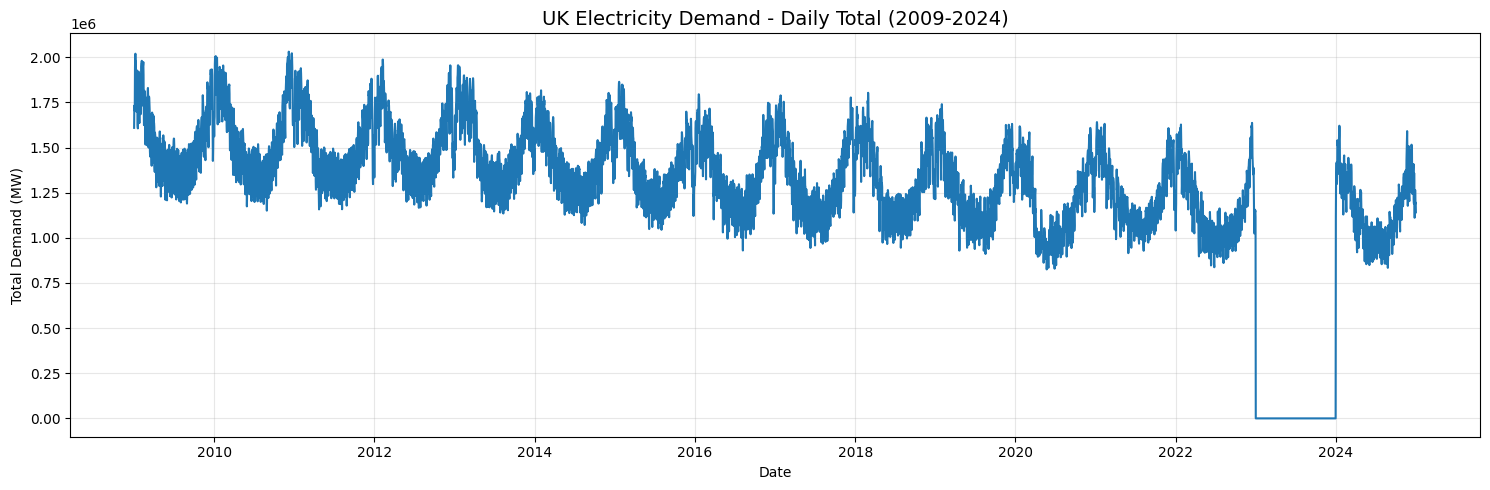

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(df_daily.index, df_daily.values)
plt.title('UK Electricity Demand - Daily Total (2009-2024)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Demand (MW)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Stationarity Testing

Following CloudAI '1 - Stationarity.ipynb', we test for stationarity using:
1. **ADF Test** (Augmented Dickey-Fuller): H0 = non-stationary. Low p-value → reject H0 → stationary
2. **KPSS Test**: H0 = stationary. High p-value → accept H0 → stationary

In [8]:
# ADF Test
adf_result = adfuller(df_daily.dropna())
print("="*70)
print("ADF TEST (Augmented Dickey-Fuller)")
print("="*70)
print(f"Test Statistic: {adf_result[0]:.6f}")
print(f"P-value: {adf_result[1]:.6f}")
print(f"Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.3f}")

if adf_result[1] < 0.05:
    print("\n✅ Result: STATIONARY (p < 0.05, reject H0)")
else:
    print("\n❌ Result: NON-STATIONARY (p >= 0.05, fail to reject H0)")

ADF TEST (Augmented Dickey-Fuller)
Test Statistic: -3.046095
P-value: 0.030808
Critical Values:
  1%: -3.431
  5%: -2.862
  10%: -2.567

✅ Result: STATIONARY (p < 0.05, reject H0)


In [9]:
# KPSS Test
kpss_result = kpss(df_daily.dropna(), regression='c')
print("\n" + "="*70)
print("KPSS TEST")
print("="*70)
print(f"Test Statistic: {kpss_result[0]:.6f}")
print(f"P-value: {kpss_result[1]:.6f}")
print(f"Critical Values:")
for key, value in kpss_result[3].items():
    print(f"  {key}: {value:.3f}")

if kpss_result[1] > 0.05:
    print("\n✅ Result: STATIONARY (p > 0.05, accept H0)")
else:
    print("\n❌ Result: NON-STATIONARY (p <= 0.05, reject H0)")


KPSS TEST
Test Statistic: 5.615364
P-value: 0.010000
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739

❌ Result: NON-STATIONARY (p <= 0.05, reject H0)


## Autocorrelation Analysis

Following CloudAI '2 - Autocorrelation.ipynb':
- **ACF (Autocorrelation Function)**: Shows correlation with lagged values
- **PACF (Partial Autocorrelation Function)**: Shows direct correlation after removing intermediate lags

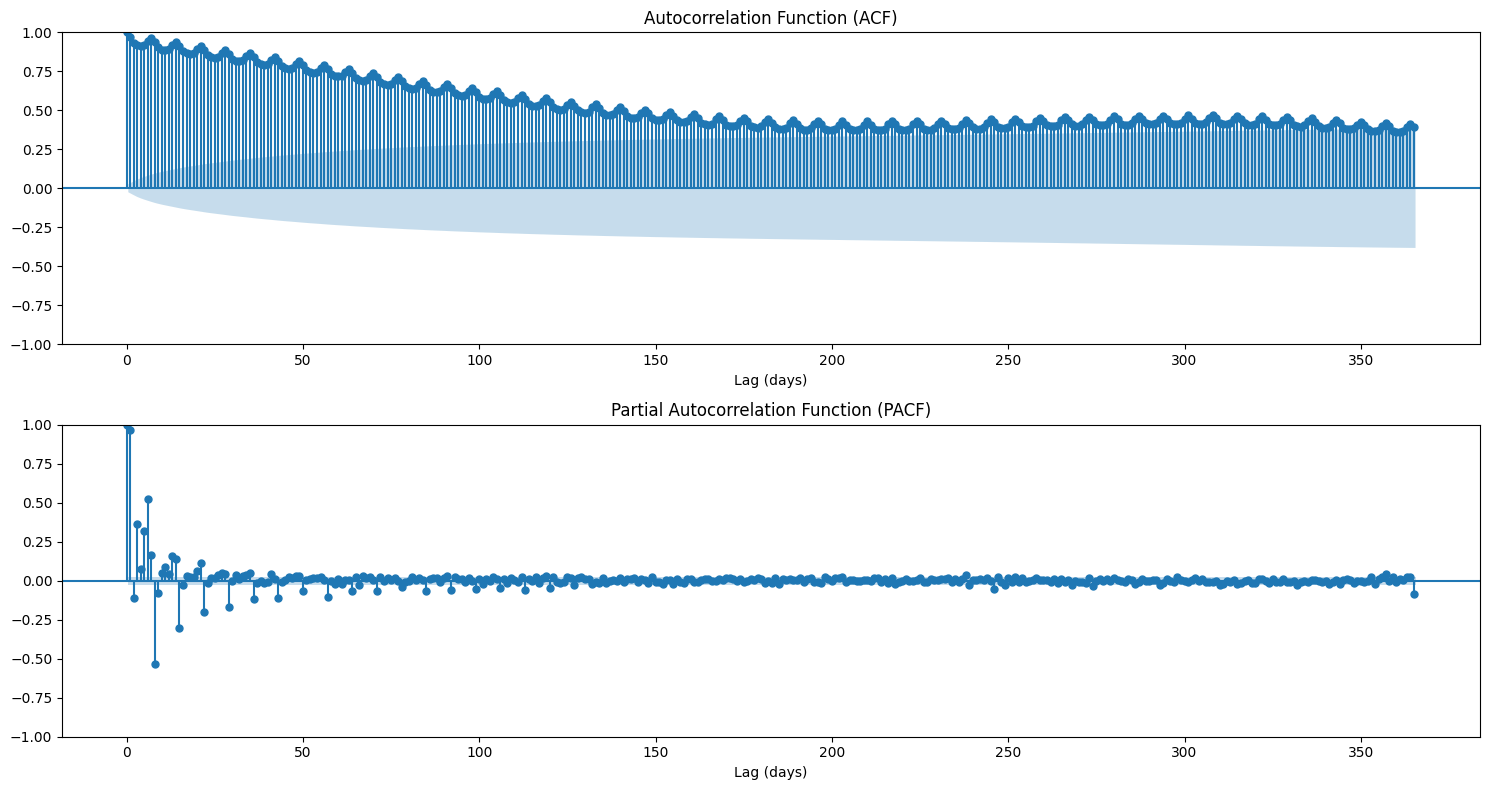

In [10]:
# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# ACF
plot_acf(df_daily.dropna(), lags=365, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=12)
axes[0].set_xlabel('Lag (days)')

# PACF
plot_pacf(df_daily.dropna(), lags=365, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12)
axes[1].set_xlabel('Lag (days)')

plt.tight_layout()
plt.show()

## Seasonal Decomposition

Decompose time series into:
- **Trend**: Long-term progression
- **Seasonal**: Repeating patterns
- **Residual**: Random noise

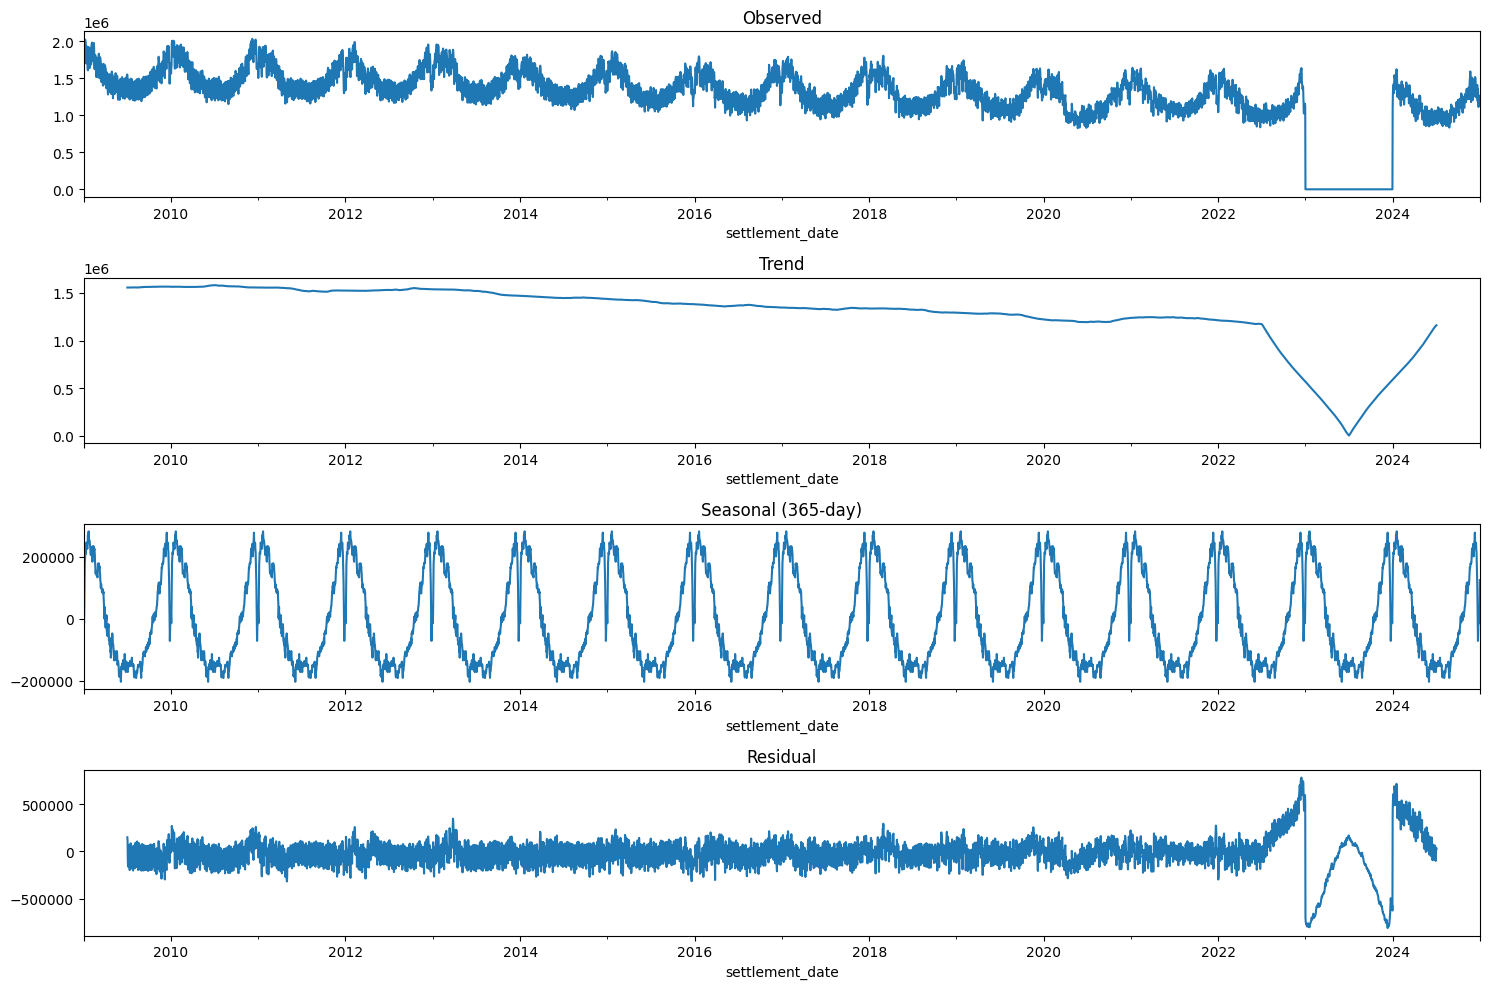

In [11]:
# Seasonal decomposition (yearly seasonality = 365 days)
decomposition = seasonal_decompose(df_daily.dropna(), model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(15, 10))

decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal (365-day)')
decomposition.resid.plot(ax=axes[3], title='Residual')

plt.tight_layout()
plt.show()

## Analysis Summary

This notebook analyzed the UK electricity demand time series and found:
1. **Stationarity**: Results from ADF and KPSS tests indicate presence of trend/seasonality
2. **Autocorrelation**: Strong correlation with lagged values (especially 7-day and 365-day patterns)
3. **Seasonality**: Clear yearly seasonal patterns visible in decomposition

**Next Steps**: Build forecasting models (ARIMA, Prophet, PyCaret comparison)